In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick

from math import radians, cos, sin, asin, sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

date_format = '%Y-%m-%d %H:%M:%S'

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

def load_data(file_paths, sample_rate):
    data_arr = [
        dd.read_csv(file_path).sample(frac=sample_rate, random_state=SEED)
        for file_path in file_paths
    ]
    data = dd.concat(data_arr)
    return data

def preprocess_data(data):
    data = data.assign(
        started_at=dd.to_datetime(data.started_at, format=date_format),
        ended_at=dd.to_datetime(data.ended_at, format=date_format)
    )
    data = data.assign(
        start_hour=data.started_at.dt.hour,
        week=data.started_at.dt.week
    )
    return data

def compute_trips_per_start_hour(data):
    trips_per_start_hour = data.groupby(['week', 'start_hour']).agg({'ride_id': 'count'})
    trips_per_start_hour = trips_per_start_hour.compute().unstack()
    trips_per_start_hour.columns = trips_per_start_hour.columns.droplevel()
    return trips_per_start_hour

def plot_trips_per_hour_heatmap(trips_per_start_hour):
    ax = plt.axes()
    sns.heatmap(trips_per_start_hour)
    ax.set_title('Trips Per Hour Heatmap')
    plt.show()

def get_all_stations(data):
    all_stations = set(
        list(data.start_station_id.dropna().unique()) +
        list(data.end_station_id.dropna().unique()))
    stations_data = pd.DataFrame(index=all_stations)
    return stations_data

def compute_additional_columns(data):
    data = data.assign(
        trip_time=(data.ended_at - data.started_at).dt.seconds
    )
    data = data.assign(
        distance=data.apply(lambda x: haversine(x.start_lng, x.start_lat, x.end_lng, x.end_lat), axis=1)
    )
    data = data.assign(
        is_member=data.member_casual == 'member',
        is_casual=data.member_casual == 'casual',
        weekday=data.started_at.dt.weekday,
        is_peak_hour=data.start_hour.isin([8, 17, 18, 19])
    )
    data = data.assign(
        is_weekend=data.weekday > 5,
        is_weekday=data.weekday <= 5
    )
    return data

def compute_avg_daily_trips(data):
    avg_daily_trips = data.compute().groupby(
        ['end_station_id', 'weekday', 'is_weekday'],
        as_index=False).agg(avg_daily_trip=('ride_id', 'count'))
    avg_daily_trips = avg_daily_trips.query('is_weekday').groupby(['end_station_id']).agg(
        weekday_daily_avg_trip=('avg_daily_trip', 'mean'))
    return avg_daily_trips

def compute_start_agg(data):
    start_agg = data.compute().groupby('start_station_id').agg(
        total_trips_start=('ride_id', 'nunique'),
        avg_distance_start=('distance', 'mean'),
        avg_trip_time_start=('trip_time', 'mean'),
        member_trips_start=('is_member', 'sum'),
        perc_casual_trips_start=('is_casual', 'mean'),
        weekend_trips_start=('is_weekend', 'sum'),
        weekday_trips_start=('is_weekday', 'sum'),
        perc_weekend_trips_start=('is_weekend', 'mean'),
        perc_weekday_trips_start=('is_weekday', 'mean'),
        perc_peak_hour_trips_start=('is_peak_hour', 'mean')
    )
    return start_agg

def compute_end_agg(data):
    end_agg = data.compute().groupby('end_station_id').agg(
        total_trips_end=('ride_id', 'nunique'),
        avg_distance_end=('distance', 'mean'),
        avg_trip_time_end=('trip_time', 'mean'),
        station_lat=('end_lat', 'mean'),
        station_lng=('end_lng', 'mean'),
        member_trips_end=('is_member', 'sum'),
        perc_casual_trips_end=('is_casual', 'mean'),
        weekend_trips_end=('is_weekend', 'sum'),
        weekday_trips_end=('is_weekday', 'sum'),
        perc_weekend_trips_end=('is_weekend', 'mean'),
        perc_weekday_trips_end=('is_weekday', 'mean'),
        perc_peak_hour_trips_end=('is_peak_hour', 'mean')
    )
    return end_agg

def join_station_data(stations_data, start_agg, end_agg, avg_daily_trips):
    stations_data = stations_data.join(start_agg).join(end_agg).join(avg_daily_trips)
    stations_data = stations_data.assign(total_trips=stations_data.total_trips_start.fillna(0) + stations_data.total_trips_end.fillna(0))
    return stations_data

def filter_stations_data(stations_data, min_trips):
    return stations_data.query(f'total_trips >= {min_trips}')

def scale_and_cluster_stations_data(stations_data_filtered, columns, n_clusters):
    scaler = StandardScaler()
    scaled_stations = pd.DataFrame(
        scaler.fit_transform(stations_data_filtered),
        columns=stations_data_filtered.columns,
        index=stations_data_filtered.index
    )
    X = scaled_stations[columns].to_numpy()

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    return cluster_labels

In [4]:
DATA_FILE_PATHS = [f"data/JC-2022{i:02d}-citibike-tripdata.csv" for i in range(1, 12)]
SEED = 10
data = load_data(DATA_FILE_PATHS, 0.1)
data = preprocess_data(data)

# Compute trips per start hour and plot heatmap
trips_per_start_hour = compute_trips_per_start_hour(data)
# plot_trips_per_hour_heatmap(trips_per_start_hour)

# Compute additional columns, average daily trips, and station aggregations
data = compute_additional_columns(data)
avg_daily_trips = compute_avg_daily_trips(data)
all_stations = get_all_stations(data)
start_agg = compute_start_agg(data)
end_agg = compute_end_agg(data)

# Join station data and filter stations
stations_data = join_station_data(all_stations, start_agg, end_agg, avg_daily_trips)
stations_data_filtered = filter_stations_data(stations_data, 1000)


/opt/conda/miniconda3/lib/python3.8/site-packages/dask/dataframe/accessor.py:88: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if callable(getattr(self._meta, key)):
/opt/conda/miniconda3/lib/python3.8/site-packages/dask/dataframe/accessor.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  out = getattr(getattr(obj, accessor, obj), attr)
/opt/conda/miniconda3/lib/python3.8/site-packages/dask/dataframe/accessor.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  out = getattr(getattr(obj, accessor, obj), attr)
/opt/conda/miniconda3/lib/python3.8/site-packages/dask/dataframe/core.py:4441: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess

/opt/conda/miniconda3/lib/python3.8/site-packages/dask/dataframe/accessor.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  out = getattr(getattr(obj, accessor, obj), attr)
/opt/conda/miniconda3/lib/python3.8/site-packages/dask/dataframe/accessor.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  out = getattr(getattr(obj, accessor, obj), attr)
/opt/conda/miniconda3/lib/python3.8/site-packages/dask/dataframe/accessor.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  out = getattr(getattr(obj, accessor, obj), attr)
/opt/conda/miniconda3/lib/python3.8/site-packages/dask/dataframe/accessor.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  out = getattr

<AxesSubplot:title={'center':'Trips Per Hour Heatmap'}>

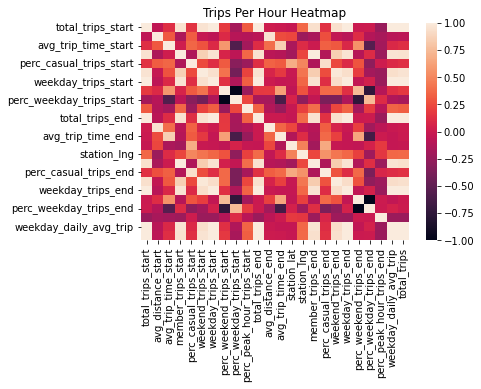

In [5]:
correlation = stations_data_filtered.corr()
ax = plt.axes()

ax.set_title('Trips Per Hour Heatmap')
sns.heatmap(correlation)

CLUSTERING

In [6]:
columns = [
    'station_lat', 'station_lng',
    'total_trips_start', 'total_trips_end',
    'avg_trip_time_start', 'avg_trip_time_end',
    'perc_casual_trips_start', 'perc_casual_trips_end',
    'perc_weekend_trips_start'
    ]

scaler = StandardScaler()
scaled_stations = pd.DataFrame(
    scaler.fit_transform(stations_data_filtered),
    columns=stations_data_filtered.columns,
    index=stations_data_filtered.index
    )
X = scaled_stations[columns].to_numpy()

For n_clusters = 2, The average silhouette_score is : 0.2662487497873477
For n_clusters = 3, The average silhouette_score is : 0.2703770058977224
For n_clusters = 4, The average silhouette_score is : 0.2899913435666497
For n_clusters = 5, The average silhouette_score is : 0.3086962154963461
For n_clusters = 6, The average silhouette_score is : 0.32093732498628846
For n_clusters = 7, The average silhouette_score is : 0.29773907751574075
For n_clusters = 8, The average silhouette_score is : 0.2893299553314167


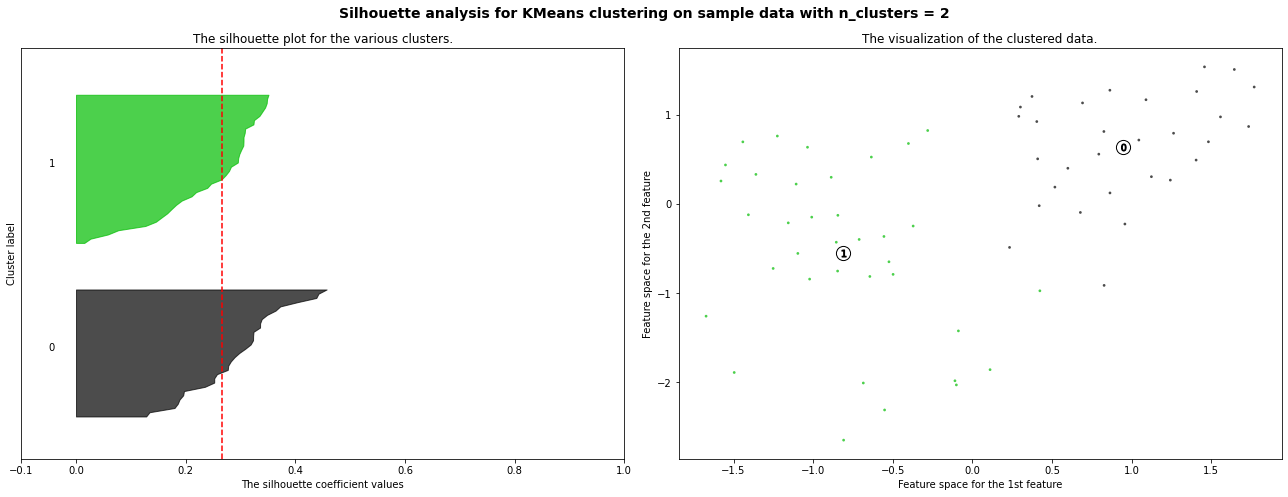

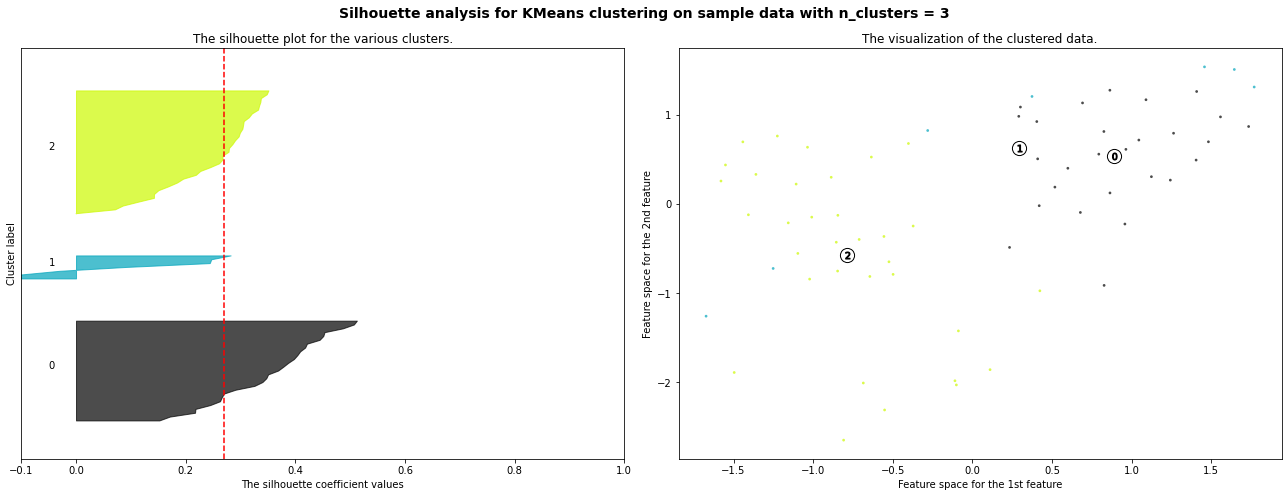

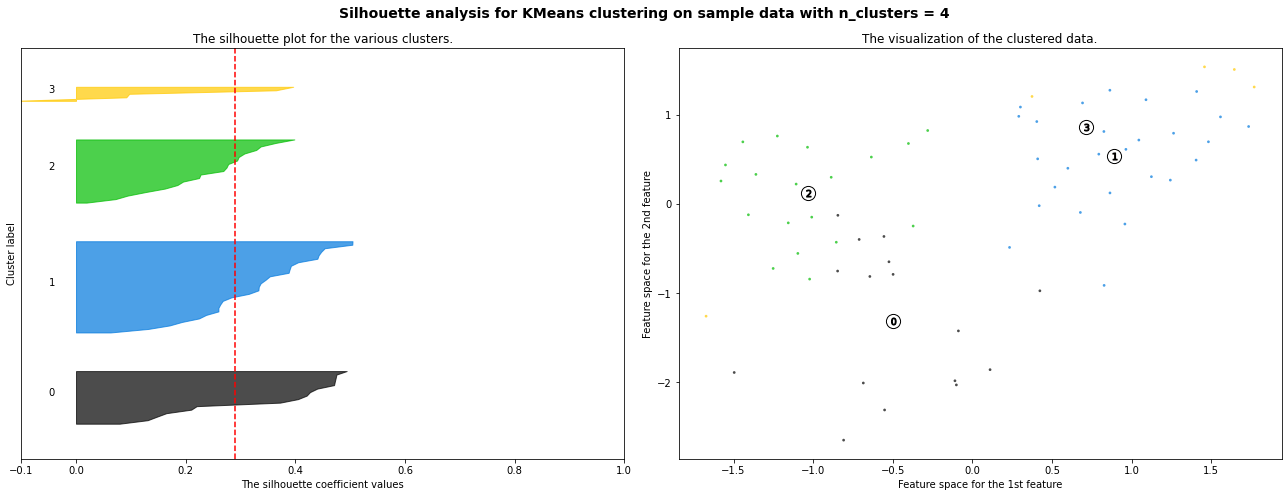

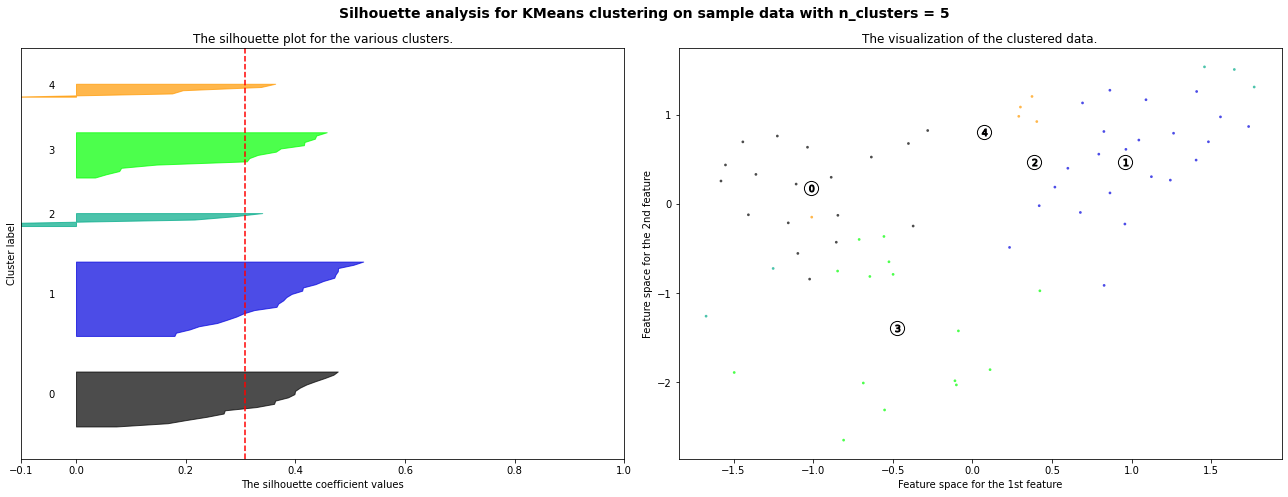

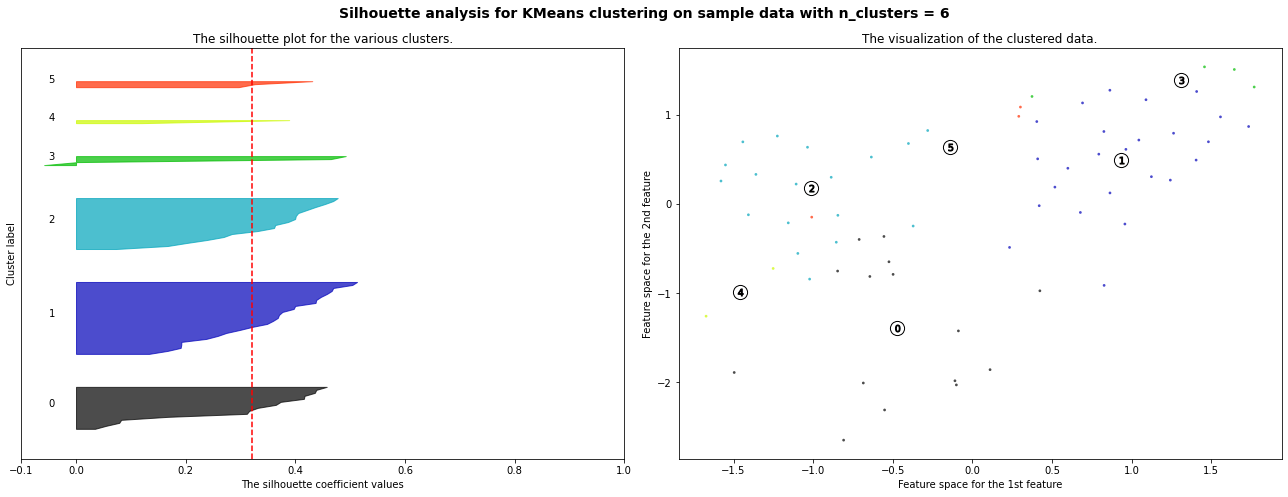

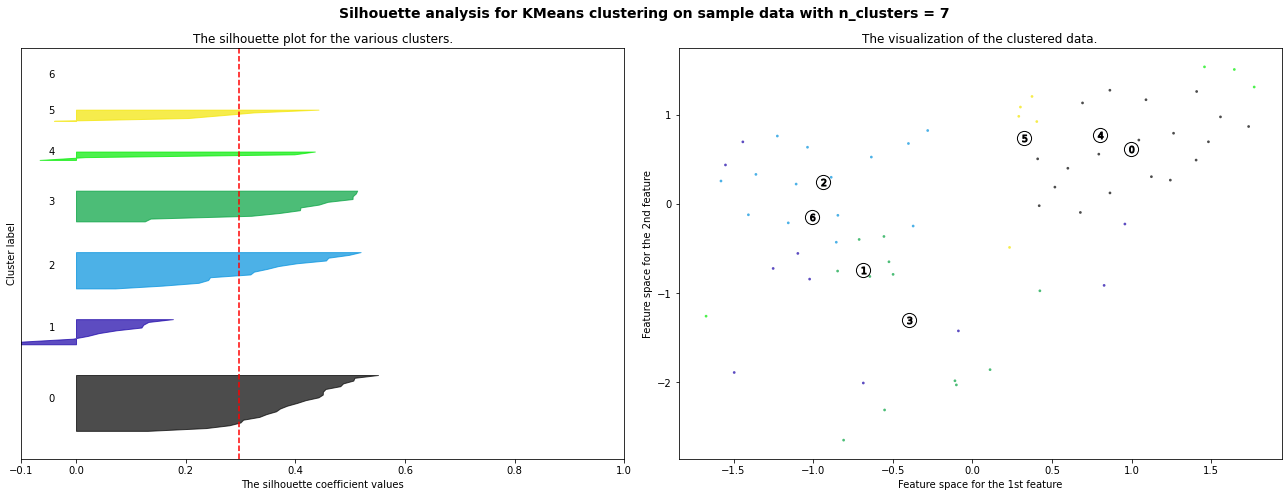

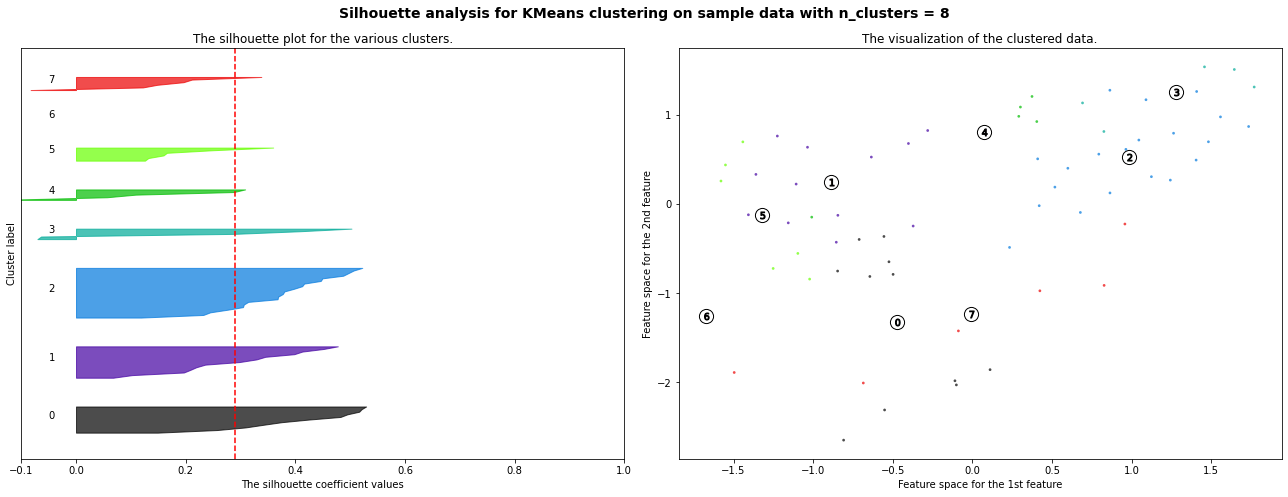

In [8]:
def plot_silhouette(ax1, n_clusters, X, cluster_labels, silhouette_avg):
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

def plot_clusters(ax2, n_clusters, X, cluster_labels, cluster_centers):
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    ax2.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

    for i, c in enumerate(cluster_centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    plot_silhouette(ax1, n_clusters, X, cluster_labels, silhouette_avg)

    cluster_centers = clusterer.cluster_centers_
    plot_clusters(ax2, n_clusters, X, cluster_labels, cluster_centers)

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    #plt.savefig(f'./plots/silhouette_analysis_{n_clusters}_clusters.png')

plt.show()